In [1]:
cd ..

/home/jovyan/dsi_plus/Projects/Project-4-semantic_search


In [2]:
%run lib/__init__.py
%matplotlib inline

# Project 4 - Semantic Search

## Latent Semantic search - model development

 - build corpus
 - vectorize with tfidf
 - reduce dimmenions with SVD
 - explore feattures - amend data cleaning and iterate 
 - build search function

Restricted modle development proces to 2000 pages out of 5603 available - this was too much for memory and kept crashing kernel. For production model data as been kept in sparse matrix until final step.

In [3]:
myWiki=MyWikiDB()

In [4]:
cat_loaded_cllr=myWiki.dbr.loads_collection

In [5]:
cursor=cat_loaded_cllr.find()
loaded=list(cursor)
loaded

[{'_id': ObjectId('5a22fb42cd7a89048f93ca2e'),
  'loaded': 'Sat Dec  2 19:13:06 2017',
  'master_cat': 'Category:Machine learning',
  'sub_cats_added': 48},
 {'_id': ObjectId('5a230356cd7a89053addcc84'),
  'loaded': 'Sat Dec  2 19:47:34 2017',
  'master_cat': 'Category:Business software',
  'sub_cats_added': 206}]

In [6]:
pages_cllr=myWiki.dbr.page_collection

In [7]:
pages_cllr.find().count()

5603

In [8]:
cursor=pages_cllr.find()
pages=list(cursor)

In [9]:
corpus_df=pd.DataFrame(pages[:2000])
corpus_df.head()

,_id,category_list,extract,ns,pageid,pull_category,title
0,43385931,[Category:All articles lacking in-text citatio...,data exploration approach similar initial datu...,0,43385931,Category:Machine learning,Data exploration
1,49082762,"[Category:Artificial intelligence, Category:CS...",these dataset use machine learn research cite ...,0,49082762,Category:Machine learning,List of datasets for machine learning research
2,233488,[Category:All articles with unsourced statemen...,machine learn field computer science give comp...,0,233488,Category:Machine learning,Machine learning
3,53587467,"[Category:Artificial intelligence, Category:Co...",the follow outline provide overview topical gu...,0,53587467,Category:Machine learning,Outline of machine learning
4,3771060,"[Category:Data mining, Category:Machine learni...",the accuracy paradox predictive analytic state...,0,3771060,Category:Machine learning,Accuracy paradox


In [10]:
columns_to_drop=['ns', 'category_list','pull_category', '_id']
corpus_df.drop(columns_to_drop, axis=1, inplace=True)

In [11]:
corpus_df.set_index('title', inplace=True)

In [12]:
corpus_df.head()

,extract,pageid
title,,
Data exploration,data exploration approach similar initial datu...,43385931
List of datasets for machine learning research,these dataset use machine learn research cite ...,49082762
Machine learning,machine learn field computer science give comp...,233488
Outline of machine learning,the follow outline provide overview topical gu...,53587467
Accuracy paradox,the accuracy paradox predictive analytic state...,3771060


In [13]:
corpus_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, Data exploration to Sy.Med Development
Data columns (total 2 columns):
extract    2000 non-null object
pageid     2000 non-null int64
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


## Abreviations to use in code
* dtm = document term matrix
* dtma= augmented document term matrix - including search term
* sp = sparse as apposed to df = dataframe
* svdm= singular value decomposition matrix  - by component
* svdma= singular value decomposition augmented matrix  - including search term
* tfidf_v= TFiDF Vectorizer
* svd_v= svd vectorizer
* lsa= Latent Semantic Analysis
* sterm= search term

### Label encode the title

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

In [15]:
le=LabelEncoder()
corpus_df['title_numerical'] = le.fit_transform(corpus_df.index)

In [16]:
corpus_df.head(4)

,extract,pageid,title_numerical
title,,,
Data exploration,data exploration approach similar initial datu...,43385931,394
List of datasets for machine learning research,these dataset use machine learn research cite ...,49082762,1028
Machine learning,machine learn field computer science give comp...,233488,1079
Outline of machine learning,the follow outline provide overview topical gu...,53587467,1331


### Prepare for DTM

In [17]:
tfidf_v = TfidfVectorizer(min_df = 2, stop_words = 'english')

In [18]:
%%time
dtm_sp = tfidf_v.fit_transform(corpus_df.extract)

CPU times: user 750 ms, sys: 0 ns, total: 750 ms
Wall time: 745 ms


In [19]:
dtm_sp

<2000x16450 sparse matrix of type '<class 'numpy.float64'>'
	with 405080 stored elements in Compressed Sparse Row format>

In [20]:
dtm_df = pd.DataFrame(dtm_sp.toarray(),
                                       index=corpus_df.index,
                                       columns=tfidf_v.get_feature_names())

In [21]:
dtm_df.T.head(10)

title,Data exploration,List of datasets for machine learning research,Machine learning,Outline of machine learning,Accuracy paradox,Action model learning,Active learning (machine learning),Adversarial machine learning,AIVA,AIXI,...,Mpedigree,MyFitnessPal,NHS Pathways,Nomad Health,Patient-Reported Outcomes Measurement Information System,Preventice,Searchmedica,SleepBot,Simulation Open Framework Architecture,Sy.Med Development
10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aa,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaa,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaai,0.0,0.0,0.0,0.0,0.0,0.037698,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaas,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aab,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aachen,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aai,0.0,0.0,0.0,0.0,0.0,0.055074,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aalborg,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
dtm_df.shape

(2000, 16450)

### Compute SVD matrix

In [23]:
n_components = 200
svd_v = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [24]:
%%time
svdm = svd_v.fit_transform(dtm_df)

CPU times: user 7.84 s, sys: 2.01 s, total: 9.85 s
Wall time: 2.64 s


In [25]:
sum(svd_v.explained_variance_ratio_)

0.37878313725823798

<Container object of 200 artists>

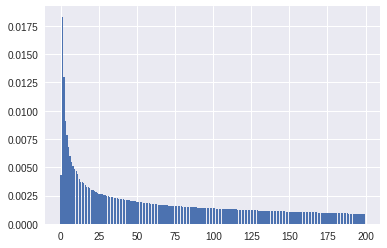

In [26]:
plt.bar(range(n_components), svd_v.explained_variance_ratio_)

In [27]:
lsa = pd.DataFrame(svdm,index=dtm_df.index,columns=component_names)
lsa['extract'] = corpus_df.extract
lsa['pageid'] = corpus_df.pageid

In [28]:
lsa.head(3)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_193,component_194,component_195,component_196,component_197,component_198,component_199,component_200,extract,pageid
title,,,,,,,,,,,,,,,,,,,,,
Data exploration,0.293488,0.055921,-0.083575,0.050645,0.104846,-0.100178,-0.064506,-0.035661,-0.166552,-0.072940,...,-0.017729,0.018882,-0.010082,-0.002121,-0.042671,0.006279,-0.016642,0.002731,data exploration approach similar initial datu...,43385931
List of datasets for machine learning research,0.268562,0.119507,-0.008513,-0.031241,0.105161,-0.100194,-0.133124,-0.042526,-0.146122,-0.047903,...,-0.051758,-0.018290,0.017342,-0.032711,0.032497,-0.027877,0.007498,0.032365,these dataset use machine learn research cite ...,49082762
Machine learning,0.543668,0.340026,0.020512,-0.177385,0.140669,-0.195899,-0.264942,0.044038,-0.092273,-0.154178,...,0.007076,-0.009464,-0.025944,-0.001303,-0.019018,0.004990,-0.019513,0.031472,machine learn field computer science give comp...,233488


In [29]:
lsa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, Data exploration to Sy.Med Development
Columns: 202 entries, component_1 to pageid
dtypes: float64(200), int64(1), object(1)
memory usage: 3.1+ MB


In [30]:
comp_features = pd.DataFrame(svd_v.components_,index=component_names,columns=tfidf_v.get_feature_names()).T

### Look at feature breakdown of components
Lots of numbers, and symbols - need to remove

In [31]:
# Feature breakdown of componentes
top_20={}
for i in range(1,20):
    comp_features['abs_component_{}'.format(i)] = np.abs(comp_features['component_{}'.format(i)])

In [32]:
comp_features['abs_component_1'].sort_values(ascending=False).head(20)

learn         0.167438
use           0.166203
datum         0.162498
software      0.160104
model         0.155730
algorithm     0.146011
network       0.131589
management    0.129409
game          0.127864
pron          0.119520
company       0.117530
business      0.113426
function      0.098043
neural        0.097220
base          0.092395
cluster       0.091220
conjurer      0.087415
machine       0.086201
train         0.084537
set           0.084060
Name: abs_component_1, dtype: float64

## Search process

1. input search term and vectorize using fitted TFIDF
2. Append search term to the DTM -> augmented DTM
3. SVD fit & transform on augemented DTM - > updated components
4. identify index for search term vector in svd matrix
5. Use cosine similarity to find most similar vectors in svd matrix

In [33]:
search_term='random forests'

In [34]:
s_term=[search_term]

#vectorize search term with TFIDF vectorizer (previously fitted)
s_term_encoded=tfidf_v.transform(s_term)
s_term_encoded_df = pd.DataFrame(s_term_encoded.toarray(), 
                                   index=['search_term'], 
                                   columns=tfidf_v.get_feature_names())

In [35]:
s_term_encoded_df

,10,20,aa,aaa,aaai,aaas,aab,aachen,aai,aalborg,...,zope,zoubin,zquez,zu,zuben,zupan,zur,zurada,zurich,zx
search_term,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
dtma_df=()

In [37]:
%%time
#add to existing document term matrix
dtma_df=dtm_df.append(s_term_encoded_df)

CPU times: user 10 ms, sys: 80 ms, total: 90 ms
Wall time: 89.7 ms


In [38]:
dtma_df.shape

(2001, 16450)

In [39]:
%%time
#re fit SVD to augmented document term matrix
component_names = ["component_"+str(i+1) for i in range(svd_v.n_components)]
svdma=svd_v.fit_transform(dtma_df)
svdma_df=pd.DataFrame(svdma,index=dtma_df.index,columns=component_names)

CPU times: user 7.98 s, sys: 2.1 s, total: 10.1 s
Wall time: 2.66 s


In [40]:
#find index of search term in refit SVD matrix
s_term_svd_vector=svdma_df.loc['search_term',:].values.reshape(1,-1)

In [41]:
#calculate cosine similarty of search term against other SVD vectors
svdma_df['cosine_sim'] = cosine_similarity(svdma_df, s_term_svd_vector)

In [42]:
print('top 20 wiki pages that are related to search term = {}'.format(s_term))
svdma_df[['cosine_sim']].sort_values('cosine_sim', ascending=False).head(10)
    

top 20 wiki pages that are related to search term = ['random forests']


,cosine_sim
search_term,1.000000
Random indexing,0.677873
Random projection,0.555238
Clustering illusion,0.482847
Random forest,0.448613
Out-of-bag error,0.422294
Random subspace method,0.413287
Markov random field,0.392569
Cuckoo search,0.367007
Hidden Markov random field,0.366369
